In [17]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [18]:
# Load data
df = pd.read_csv("../data/sierraleone-bumbuna.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [19]:
# Summary
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-30 12:00:30.000000768,201.957515,116.376337,113.720571,206.643095,198.114691,26.319394,79.448857,1.146113,1.691606,0.363823,133.044668,7.172220,999.876469,0.000967,0.004806,32.504263,32.593091,NaN
min,2021-10-30 00:01:00,-19.500000,-7.800000,-17.900000,0.000000,0.000000,12.300000,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,993.000000,0.000000,0.000000,10.700000,11.100000,NaN
25%,2022-01-29 06:00:45,-2.800000,-0.300000,-3.800000,0.000000,0.000000,23.100000,68.700000,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,0.000000,23.500000,23.800000,NaN
50%,2022-04-30 12:00:30,0.300000,-0.100000,-0.100000,3.600000,3.400000,25.300000,85.400000,0.800000,1.600000,0.400000,161.500000,6.200000,1000.000000,0.000000,0.000000,26.600000,26.900000,NaN
75%,2022-07-30 18:00:15,362.400000,107.000000,224.700000,359.500000,345.400000,29.400000,96.700000,2.000000,2.600000,0.600000,234.100000,12.000000,1001.000000,0.000000,0.000000,40.900000,41.300000,NaN
max,2022-10-30 00:00:00,1499.000000,946.000000,892.000000,1507.000000,1473.000000,39.900000,100.000000,19.200000,23.900000,4.100000,360.000000,98.400000,1006.000000,1.000000,2.400000,72.800000,70.400000,NaN
std,NaN,298.495150,218.652659,158.946032,300.896893,288.889073,4.398605,20.520775,1.239248,1.617053,0.295000,114.284792,7.535093,2.104419,0.031074,0.047556,12.434899,12.009161,NaN


In [20]:
# Missing values
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_report = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
missing_report[missing_report['Percent'] > 5]

,Missing,Percent
Comments,525600,100.0


In [21]:
# Z-score outlier filtering
z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[z_cols].apply(zscore)
outlier_mask = (np.abs(z_scores) > 3)

In [22]:
# Drop rows with extreme values
df_clean = df[(~outlier_mask).all(axis=1)].copy()

In [23]:
df_clean.fillna(df_clean.median(numeric_only=True), inplace=True)

In [24]:
# Save cleaned version
import os
os.makedirs("../data", exist_ok=True)
df_clean.to_csv("../data/sierraleone_clean.csv", index=False)

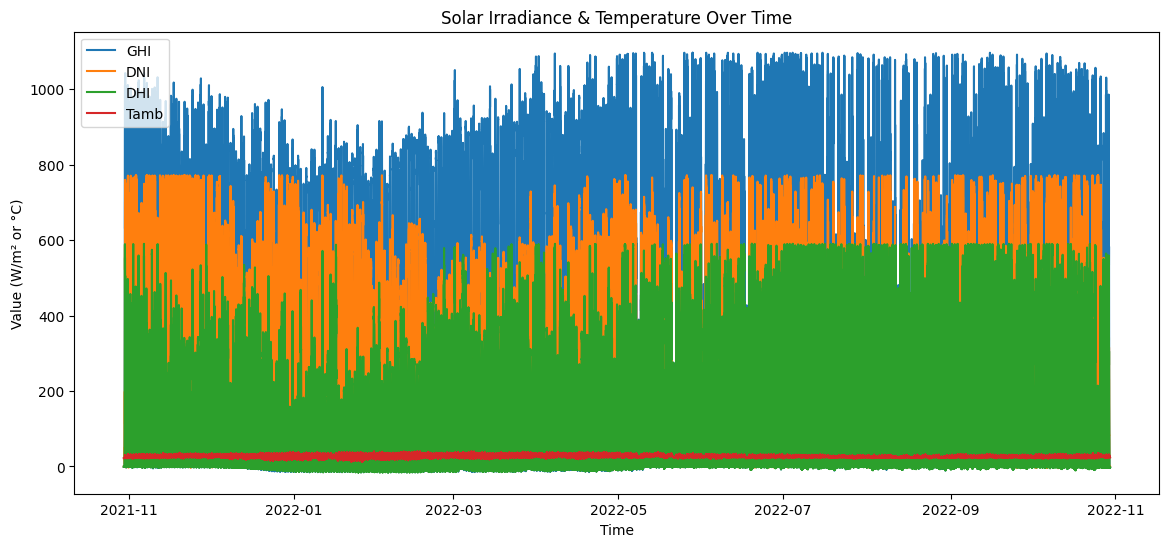

In [25]:
plt.figure(figsize=(14, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df_clean['Timestamp'], df_clean[col], label=col)
plt.legend()
plt.title("Solar Irradiance & Temperature Over Time")
plt.xlabel("Time")
plt.ylabel("Value (W/m² or °C)")
plt.show()

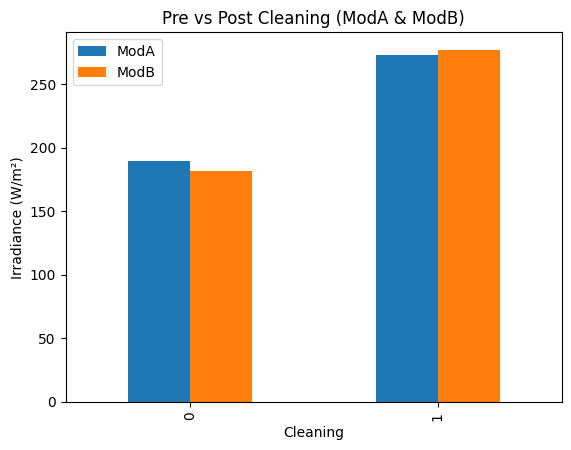

In [26]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
plt.title("Pre vs Post Cleaning (ModA & ModB)")
plt.ylabel("Irradiance (W/m²)")
plt.show()

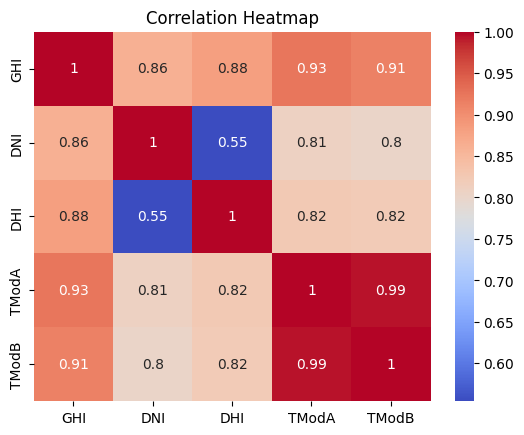

In [27]:
corr = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

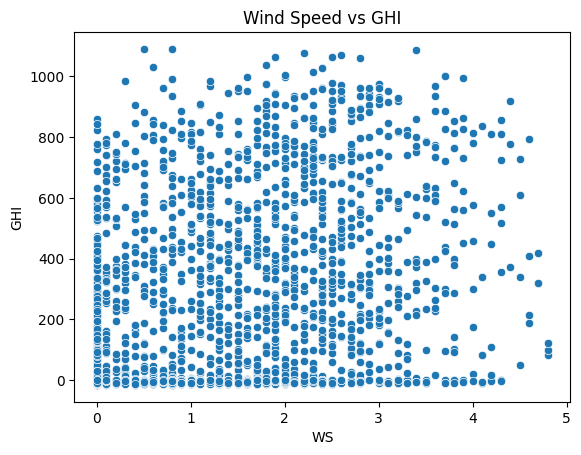

In [28]:
# Relationship: WS vs GHI
sns.scatterplot(data=df_clean.sample(3000), x='WS', y='GHI')
plt.title("Wind Speed vs GHI")
plt.show()

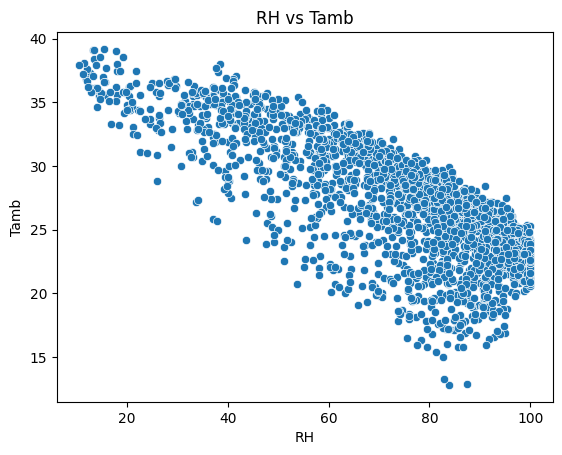

In [29]:
# Relationship: RH vs Tamb
sns.scatterplot(data=df_clean.sample(3000), x='RH', y='Tamb')
plt.title("RH vs Tamb")
plt.show()

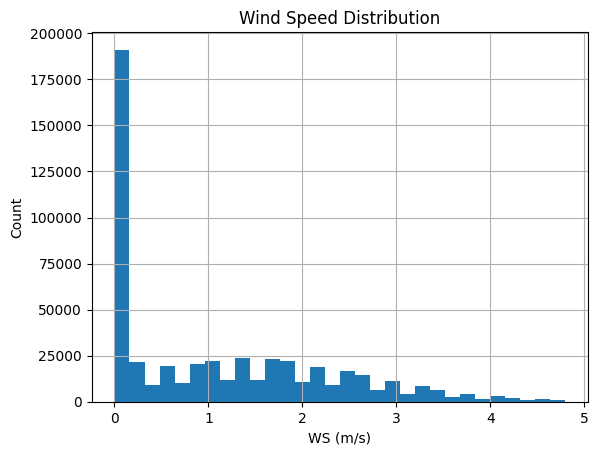

In [30]:
# Histogram of WS
df_clean['WS'].hist(bins=30)
plt.title("Wind Speed Distribution")
plt.xlabel("WS (m/s)")
plt.ylabel("Count")
plt.show()

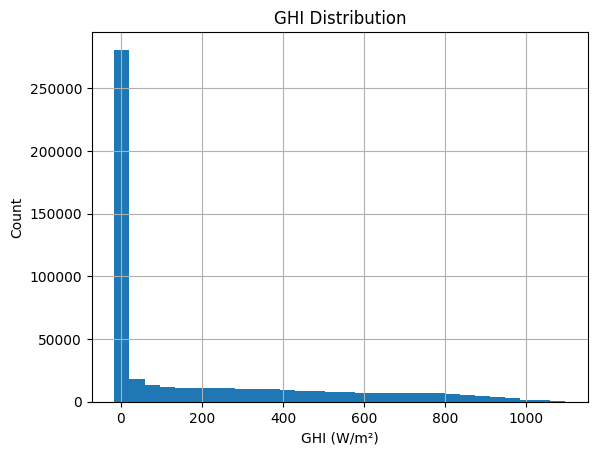

In [31]:
# Histogram of GHI
df_clean['GHI'].hist(bins=30)
plt.title("GHI Distribution")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Count")
plt.show()

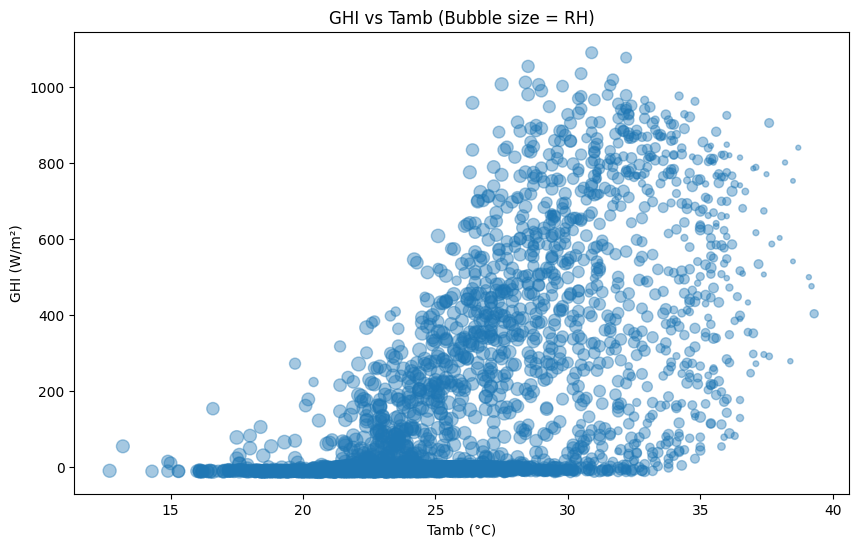

In [32]:
# GHI vs Tamb, Bubble Size = RH
sample = df_clean.sample(3000)
plt.figure(figsize=(10, 6))
plt.scatter(sample['Tamb'], sample['GHI'], s=sample['RH'], alpha=0.4)
plt.title("GHI vs Tamb (Bubble size = RH)")
plt.xlabel("Tamb (°C)")
plt.ylabel("GHI (W/m²)")
plt.show()